# Helper Functions

In [3]:
import json
import random
from collections import defaultdict, Counter
import itertools

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def load_json_lines(path):
    texts, labels = [], []
    with open(path, 'r') as f:
        for line in f:
            ex = json.loads(line)
            texts.append(torch.tensor(ex['text'], dtype=torch.long))
            labels.append(ex['label'])
    return texts, labels

def load_test_json(path):
    texts = []
    with open(path, 'r') as f:
        for line in f:
            ex = json.loads(line)
            texts.append(torch.tensor(ex['text'], dtype=torch.long))
    return texts


In [5]:
def create_weighted_sampler(domains, labels):
    from collections import Counter
    from torch.utils.data import WeightedRandomSampler

    bucket_keys = list(zip(domains, labels))
    bucket_counts = Counter(bucket_keys)
    bucket_weights = {k: 1.0 / count for k, count in bucket_counts.items()}
    sample_weights = torch.DoubleTensor([bucket_weights[k] for k in bucket_keys])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [6]:
def stratified_train_val_split(texts, labels, domains, val_size_per_group=60, random_state=42):
    random.seed(random_state)
    from collections import defaultdict
    buckets = defaultdict(list)

    for x, y, d in zip(texts, labels, domains):
        buckets[(d, y)].append((x, y, d))

    train, val = [], []
    for key in buckets:
        group = buckets[key]
        random.shuffle(group)
        n_val = min(val_size_per_group, len(group))
        val.extend(group[:n_val])
        train.extend(group[n_val:])

    random.shuffle(train)
    random.shuffle(val)
    tx, ty, td = zip(*train)
    vx, vy, vd = zip(*val)
    return list(tx), list(ty), list(td), list(vx), list(vy), list(vd)


In [7]:
def train(model, train_loader, epochs, lr, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    pos_weight = torch.tensor([
        sum(1 for y in train_loader.dataset.tensors[1] if y == 0) /
        sum(1 for y in train_loader.dataset.tensors[1] if y == 1)
    ], device=device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch} — Train Loss: {total_loss / len(train_loader):.4f}")

In [21]:
def validate_return_acc(model, dataloader, all_labels, all_domains, device="cpu"):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits).squeeze()
            preds = (probs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    print(f"\nValidation Accuracy: {acc:.4f}")
    return acc

def train_with_validation(model, train_loader, val_loader, val_labels, val_domains, epochs=5, lr=1e-3, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    pos_weight = torch.tensor([
        sum(1 for y in train_loader.dataset.tensors[1] if y == 0) /
        sum(1 for y in train_loader.dataset.tensors[1] if y == 1)
    ], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    val_accuracies = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"\nEpoch {epoch} — Train Loss: {total_loss / len(train_loader):.4f}")
        val_acc = validate_return_acc(model, val_loader, val_labels, val_domains, device)
        val_accuracies.append(val_acc)

    return val_accuracies

In [16]:
def predict_with_confidence(model, dataloader, device="cpu"):
    model.eval()
    preds, probs = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting", leave=False):
            if len(batch) == 2:
                X_batch, _ = batch  # Ignore labels
            else:
                X_batch = batch[0]
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            batch_probs = torch.sigmoid(logits).squeeze()

            if batch_probs.ndim == 0:
                batch_probs = batch_probs.unsqueeze(0)

            batch_preds = (batch_probs >= 0.5).int().tolist()
            preds.extend(batch_preds)
            probs.extend(batch_probs.cpu().tolist())

    return preds, probs

# Loading and Tensorizing Data

In [11]:
# Load full data
d1_texts, d1_labels = load_json_lines("data/domain1_train_data.json")
d2_texts, d2_labels = load_json_lines("data/domain2_train_data.json")
texts = d1_texts + d2_texts
labels = d1_labels + d2_labels
domains = [0] * len(d1_labels) + [1] * len(d2_labels)

# Load test data
test_texts = load_test_json("data/test_data.json")
X_test = pad_sequence(test_texts, batch_first=True, padding_value=0)
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Tensorize full dataset, for final training
X_all = pad_sequence(texts, batch_first=True, padding_value=0)
y_all = torch.tensor(labels, dtype=torch.float32)
train_dataset_final = TensorDataset(X_all, y_all)

# Stratified validation split, get 60 validation samples of each set to mimic balance of test set
train_texts, train_labels, train_domains, val_texts, val_labels, val_domains = stratified_train_val_split(
    texts, labels, domains, val_size_per_group=60
)

# Tensorize training data, for validation-based training
X_train = pad_sequence(train_texts, batch_first=True, padding_value=0)
y_train = torch.tensor(train_labels, dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)

# Sampler for training
train_sampler = create_weighted_sampler(train_domains, train_labels)
final_sampler = create_weighted_sampler(domains, labels)

# Tensorize validation
X_val = pad_sequence(val_texts, batch_first=True, padding_value=0)
y_val = torch.tensor(val_labels, dtype=torch.float32)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# BiLSTM

In [25]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        embeds = self.embedding(x)
        _, (h_n, _) = self.lstm(embeds)
        forward_final = h_n[-2]
        backward_final = h_n[-1]
        last_hidden = torch.cat((forward_final, backward_final), dim=1)
        logits = self.fc(self.dropout(last_hidden))
        return logits.squeeze()

## Hyperparameter Tuning

In [33]:
# Define grid of values to test
bilstm_param_grid = {
    'hidden_dim': [128, 256],
    'num_layers': [1, 2],
    'dropout': [0.3, 0.5],
    'lr': [1e-3, 5e-4],
    'batch_size': [32, 64],
}

bilstm_param_combinations = list(itertools.product(*param_grid.values()))
bilstm_param_names = list(param_grid.keys())
bilstm_tuning_results = []

for params in param_combinations:
    bilstm_config = dict(zip(bilstm_param_names, bilstm_params))
    print(f"\nTesting config: {config}")

    bilstm_model = BiLSTMClassifier(
        vocab_size=17120,
        embedding_dim=128,
        hidden_dim=bilstm_config['hidden_dim'],
        num_layers=bilstm_config['num_layers'],
        dropout=bilstm_config['dropout']
    )

    train_loader = DataLoader(train_dataset, batch_size=bilstm_config['batch_size'], sampler=train_sampler)

    val_accuracies = train_with_validation(
        bilstm_model, train_loader, val_loader,
        val_labels, val_domains,
        epochs=10, lr=bilstm_config['lr'], device=device
    )

    bilstm_tuning_results.append({
        **config,
        "val_accuracy_final": val_accuracies[-1],
        "val_accuracies": val_accuracies
    })


🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1465

✅ Validation Accuracy: 0.7958



📦 Epoch 2 — Train Loss: 0.0548

✅ Validation Accuracy: 0.8500



📦 Epoch 3 — Train Loss: 0.0187

✅ Validation Accuracy: 0.8708



📦 Epoch 4 — Train Loss: 0.0114

✅ Validation Accuracy: 0.8708



📦 Epoch 5 — Train Loss: 0.0121

✅ Validation Accuracy: 0.8458



📦 Epoch 6 — Train Loss: 0.0043

✅ Validation Accuracy: 0.8667



📦 Epoch 7 — Train Loss: 0.0081

✅ Validation Accuracy: 0.8292



📦 Epoch 8 — Train Loss: 0.0044

✅ Validation Accuracy: 0.8583



📦 Epoch 9 — Train Loss: 0.0028

✅ Validation Accuracy: 0.8083



📦 Epoch 10 — Train Loss: 0.0058

✅ Validation Accuracy: 0.8042

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1850

✅ Validation Accuracy: 0.6458



📦 Epoch 2 — Train Loss: 0.0733

✅ Validation Accuracy: 0.8833



📦 Epoch 3 — Train Loss: 0.0327

✅ Validation Accuracy: 0.8875



📦 Epoch 4 — Train Loss: 0.0160

✅ Validation Accuracy: 0.8750



📦 Epoch 5 — Train Loss: 0.0098

✅ Validation Accuracy: 0.8583



📦 Epoch 6 — Train Loss: 0.0119

✅ Validation Accuracy: 0.8250



📦 Epoch 7 — Train Loss: 0.0050

✅ Validation Accuracy: 0.8625



📦 Epoch 8 — Train Loss: 0.0034

✅ Validation Accuracy: 0.8458



📦 Epoch 9 — Train Loss: 0.0022

✅ Validation Accuracy: 0.8500



📦 Epoch 10 — Train Loss: 0.0016

✅ Validation Accuracy: 0.8333

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1831

✅ Validation Accuracy: 0.5875



📦 Epoch 2 — Train Loss: 0.0836

✅ Validation Accuracy: 0.8667



📦 Epoch 3 — Train Loss: 0.0590

✅ Validation Accuracy: 0.8000



📦 Epoch 4 — Train Loss: 0.0273

✅ Validation Accuracy: 0.8708



📦 Epoch 5 — Train Loss: 0.0120

✅ Validation Accuracy: 0.8708



📦 Epoch 6 — Train Loss: 0.0088

✅ Validation Accuracy: 0.8458



📦 Epoch 7 — Train Loss: 0.0121

✅ Validation Accuracy: 0.8708



📦 Epoch 8 — Train Loss: 0.0051

✅ Validation Accuracy: 0.8417



📦 Epoch 9 — Train Loss: 0.0068

✅ Validation Accuracy: 0.8583



📦 Epoch 10 — Train Loss: 0.0038

✅ Validation Accuracy: 0.8250

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.2231

✅ Validation Accuracy: 0.5000



📦 Epoch 2 — Train Loss: 0.1224

✅ Validation Accuracy: 0.7542



📦 Epoch 3 — Train Loss: 0.0681

✅ Validation Accuracy: 0.8458



📦 Epoch 4 — Train Loss: 0.0377

✅ Validation Accuracy: 0.8708



📦 Epoch 5 — Train Loss: 0.0205

✅ Validation Accuracy: 0.8875



📦 Epoch 6 — Train Loss: 0.0189

✅ Validation Accuracy: 0.8500



📦 Epoch 7 — Train Loss: 0.0097

✅ Validation Accuracy: 0.8417



📦 Epoch 8 — Train Loss: 0.0062

✅ Validation Accuracy: 0.8292



📦 Epoch 9 — Train Loss: 0.0048

✅ Validation Accuracy: 0.8333



📦 Epoch 10 — Train Loss: 0.0041

✅ Validation Accuracy: 0.8125

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1527

✅ Validation Accuracy: 0.7958



📦 Epoch 2 — Train Loss: 0.0734

✅ Validation Accuracy: 0.8542



📦 Epoch 3 — Train Loss: 0.0249

✅ Validation Accuracy: 0.8750



📦 Epoch 4 — Train Loss: 0.0134

✅ Validation Accuracy: 0.8417



📦 Epoch 5 — Train Loss: 0.0070

✅ Validation Accuracy: 0.8542



📦 Epoch 6 — Train Loss: 0.0069

✅ Validation Accuracy: 0.8500



📦 Epoch 7 — Train Loss: 0.0034

✅ Validation Accuracy: 0.8292



📦 Epoch 8 — Train Loss: 0.0035

✅ Validation Accuracy: 0.8292



📦 Epoch 9 — Train Loss: 0.0026

✅ Validation Accuracy: 0.8208



📦 Epoch 10 — Train Loss: 0.0035

✅ Validation Accuracy: 0.8542

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1879

✅ Validation Accuracy: 0.6083



📦 Epoch 2 — Train Loss: 0.0830

✅ Validation Accuracy: 0.8458



📦 Epoch 3 — Train Loss: 0.0447

✅ Validation Accuracy: 0.8500



📦 Epoch 4 — Train Loss: 0.0169

✅ Validation Accuracy: 0.8625



📦 Epoch 5 — Train Loss: 0.0118

✅ Validation Accuracy: 0.8833



📦 Epoch 6 — Train Loss: 0.0075

✅ Validation Accuracy: 0.8417



📦 Epoch 7 — Train Loss: 0.0099

✅ Validation Accuracy: 0.8542



📦 Epoch 8 — Train Loss: 0.0031

✅ Validation Accuracy: 0.8292



📦 Epoch 9 — Train Loss: 0.0079

✅ Validation Accuracy: 0.8333



📦 Epoch 10 — Train Loss: 0.0026

✅ Validation Accuracy: 0.8333

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1975

✅ Validation Accuracy: 0.5667



📦 Epoch 2 — Train Loss: 0.0920

✅ Validation Accuracy: 0.8458



📦 Epoch 3 — Train Loss: 0.0407

✅ Validation Accuracy: 0.9042



📦 Epoch 4 — Train Loss: 0.0240

✅ Validation Accuracy: 0.8708



📦 Epoch 5 — Train Loss: 0.0163

✅ Validation Accuracy: 0.9125



📦 Epoch 6 — Train Loss: 0.0088

✅ Validation Accuracy: 0.8958



📦 Epoch 7 — Train Loss: 0.0052

✅ Validation Accuracy: 0.7875



📦 Epoch 8 — Train Loss: 0.0051

✅ Validation Accuracy: 0.8958



📦 Epoch 9 — Train Loss: 0.0035

✅ Validation Accuracy: 0.8083



📦 Epoch 10 — Train Loss: 0.0029

✅ Validation Accuracy: 0.8417

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.2270

✅ Validation Accuracy: 0.5000



📦 Epoch 2 — Train Loss: 0.1350

✅ Validation Accuracy: 0.7083



📦 Epoch 3 — Train Loss: 0.0795

✅ Validation Accuracy: 0.8250



📦 Epoch 4 — Train Loss: 0.0441

✅ Validation Accuracy: 0.8500



📦 Epoch 5 — Train Loss: 0.0265

✅ Validation Accuracy: 0.8500



📦 Epoch 6 — Train Loss: 0.0151

✅ Validation Accuracy: 0.8292



📦 Epoch 7 — Train Loss: 0.0069

✅ Validation Accuracy: 0.8542



📦 Epoch 8 — Train Loss: 0.0125

✅ Validation Accuracy: 0.8125



📦 Epoch 9 — Train Loss: 0.0051

✅ Validation Accuracy: 0.8333



📦 Epoch 10 — Train Loss: 0.0207

✅ Validation Accuracy: 0.8250

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1309

✅ Validation Accuracy: 0.8208



📦 Epoch 2 — Train Loss: 0.0381

✅ Validation Accuracy: 0.8542



📦 Epoch 3 — Train Loss: 0.0155

✅ Validation Accuracy: 0.8167



📦 Epoch 4 — Train Loss: 0.0162

✅ Validation Accuracy: 0.8417



📦 Epoch 5 — Train Loss: 0.0039

✅ Validation Accuracy: 0.8375



📦 Epoch 6 — Train Loss: 0.0038

✅ Validation Accuracy: 0.8292



📦 Epoch 7 — Train Loss: 0.0035

✅ Validation Accuracy: 0.8250



📦 Epoch 8 — Train Loss: 0.0092

✅ Validation Accuracy: 0.8250



📦 Epoch 9 — Train Loss: 0.0045

✅ Validation Accuracy: 0.8208



📦 Epoch 10 — Train Loss: 0.0019

✅ Validation Accuracy: 0.8625

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1600

✅ Validation Accuracy: 0.7917



📦 Epoch 2 — Train Loss: 0.0597

✅ Validation Accuracy: 0.8708



📦 Epoch 3 — Train Loss: 0.0298

✅ Validation Accuracy: 0.8083



📦 Epoch 4 — Train Loss: 0.0150

✅ Validation Accuracy: 0.8583



📦 Epoch 5 — Train Loss: 0.0125

✅ Validation Accuracy: 0.8333



📦 Epoch 6 — Train Loss: 0.0067

✅ Validation Accuracy: 0.7625



📦 Epoch 7 — Train Loss: 0.0077

✅ Validation Accuracy: 0.8333



📦 Epoch 8 — Train Loss: 0.0058

✅ Validation Accuracy: 0.8000



📦 Epoch 9 — Train Loss: 0.0024

✅ Validation Accuracy: 0.8000



📦 Epoch 10 — Train Loss: 0.0011

✅ Validation Accuracy: 0.7750

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1483

✅ Validation Accuracy: 0.8417



📦 Epoch 2 — Train Loss: 0.0546

✅ Validation Accuracy: 0.8458



📦 Epoch 3 — Train Loss: 0.0224

✅ Validation Accuracy: 0.8500



📦 Epoch 4 — Train Loss: 0.0186

✅ Validation Accuracy: 0.8125



📦 Epoch 5 — Train Loss: 0.0164

✅ Validation Accuracy: 0.8417



📦 Epoch 6 — Train Loss: 0.0069

✅ Validation Accuracy: 0.8375



📦 Epoch 7 — Train Loss: 0.0094

✅ Validation Accuracy: 0.8458



📦 Epoch 8 — Train Loss: 0.0060

✅ Validation Accuracy: 0.8542



📦 Epoch 9 — Train Loss: 0.0057

✅ Validation Accuracy: 0.8417



📦 Epoch 10 — Train Loss: 0.0018

✅ Validation Accuracy: 0.8458

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1872

✅ Validation Accuracy: 0.6625



📦 Epoch 2 — Train Loss: 0.0815

✅ Validation Accuracy: 0.8375



📦 Epoch 3 — Train Loss: 0.0449

✅ Validation Accuracy: 0.8583



📦 Epoch 4 — Train Loss: 0.0240

✅ Validation Accuracy: 0.8292



📦 Epoch 5 — Train Loss: 0.0169

✅ Validation Accuracy: 0.8167



📦 Epoch 6 — Train Loss: 0.0115

✅ Validation Accuracy: 0.8083



📦 Epoch 7 — Train Loss: 0.0134

✅ Validation Accuracy: 0.8042



📦 Epoch 8 — Train Loss: 0.0091

✅ Validation Accuracy: 0.8500



📦 Epoch 9 — Train Loss: 0.0058

✅ Validation Accuracy: 0.8250



📦 Epoch 10 — Train Loss: 0.0130

✅ Validation Accuracy: 0.8125

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1201

✅ Validation Accuracy: 0.8417



📦 Epoch 2 — Train Loss: 0.0494

✅ Validation Accuracy: 0.8625



📦 Epoch 3 — Train Loss: 0.0199

✅ Validation Accuracy: 0.8250



📦 Epoch 4 — Train Loss: 0.0104

✅ Validation Accuracy: 0.7833



📦 Epoch 5 — Train Loss: 0.0076

✅ Validation Accuracy: 0.8167



📦 Epoch 6 — Train Loss: 0.0061

✅ Validation Accuracy: 0.7750



📦 Epoch 7 — Train Loss: 0.0140

✅ Validation Accuracy: 0.7833



📦 Epoch 8 — Train Loss: 0.0157

✅ Validation Accuracy: 0.8167



📦 Epoch 9 — Train Loss: 0.0049

✅ Validation Accuracy: 0.7667



📦 Epoch 10 — Train Loss: 0.0022

✅ Validation Accuracy: 0.7833

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1623

✅ Validation Accuracy: 0.7292



📦 Epoch 2 — Train Loss: 0.0549

✅ Validation Accuracy: 0.8583



📦 Epoch 3 — Train Loss: 0.0219

✅ Validation Accuracy: 0.8708



📦 Epoch 4 — Train Loss: 0.0230

✅ Validation Accuracy: 0.8625



📦 Epoch 5 — Train Loss: 0.0086

✅ Validation Accuracy: 0.8542



📦 Epoch 6 — Train Loss: 0.0095

✅ Validation Accuracy: 0.8333



📦 Epoch 7 — Train Loss: 0.0034

✅ Validation Accuracy: 0.8208



📦 Epoch 8 — Train Loss: 0.0184

✅ Validation Accuracy: 0.8375



📦 Epoch 9 — Train Loss: 0.0068

✅ Validation Accuracy: 0.7917



📦 Epoch 10 — Train Loss: 0.0019

✅ Validation Accuracy: 0.8000

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1581

✅ Validation Accuracy: 0.7750



📦 Epoch 2 — Train Loss: 0.0505

✅ Validation Accuracy: 0.8208



📦 Epoch 3 — Train Loss: 0.0235

✅ Validation Accuracy: 0.8542



📦 Epoch 4 — Train Loss: 0.0089

✅ Validation Accuracy: 0.8167



📦 Epoch 5 — Train Loss: 0.0140

✅ Validation Accuracy: 0.8417



📦 Epoch 6 — Train Loss: 0.0090

✅ Validation Accuracy: 0.8708



📦 Epoch 7 — Train Loss: 0.0130

✅ Validation Accuracy: 0.8125



📦 Epoch 8 — Train Loss: 0.0058

✅ Validation Accuracy: 0.7958



📦 Epoch 9 — Train Loss: 0.0055

✅ Validation Accuracy: 0.8333



📦 Epoch 10 — Train Loss: 0.0042

✅ Validation Accuracy: 0.8125

🔍 Testing config: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1957

✅ Validation Accuracy: 0.6083



📦 Epoch 2 — Train Loss: 0.0879

✅ Validation Accuracy: 0.8458



📦 Epoch 3 — Train Loss: 0.0364

✅ Validation Accuracy: 0.8667



📦 Epoch 4 — Train Loss: 0.0207

✅ Validation Accuracy: 0.8833



📦 Epoch 5 — Train Loss: 0.0096

✅ Validation Accuracy: 0.8833



📦 Epoch 6 — Train Loss: 0.0120

✅ Validation Accuracy: 0.8708



📦 Epoch 7 — Train Loss: 0.0057

✅ Validation Accuracy: 0.8542



📦 Epoch 8 — Train Loss: 0.0052

✅ Validation Accuracy: 0.8458



📦 Epoch 9 — Train Loss: 0.0027

✅ Validation Accuracy: 0.8208



📦 Epoch 10 — Train Loss: 0.0025

✅ Validation Accuracy: 0.8167

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1420

✅ Validation Accuracy: 0.7917



📦 Epoch 2 — Train Loss: 0.0462

✅ Validation Accuracy: 0.8417



📦 Epoch 3 — Train Loss: 0.0194

✅ Validation Accuracy: 0.8667



📦 Epoch 4 — Train Loss: 0.0107

✅ Validation Accuracy: 0.8042



📦 Epoch 5 — Train Loss: 0.0095

✅ Validation Accuracy: 0.8250



📦 Epoch 6 — Train Loss: 0.0054

✅ Validation Accuracy: 0.8208



📦 Epoch 7 — Train Loss: 0.0040

✅ Validation Accuracy: 0.8417



📦 Epoch 8 — Train Loss: 0.0013

✅ Validation Accuracy: 0.8375



📦 Epoch 9 — Train Loss: 0.0008

✅ Validation Accuracy: 0.8125



📦 Epoch 10 — Train Loss: 0.0004

✅ Validation Accuracy: 0.8375

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1765

✅ Validation Accuracy: 0.7208



📦 Epoch 2 — Train Loss: 0.0731

✅ Validation Accuracy: 0.8333



📦 Epoch 3 — Train Loss: 0.0314

✅ Validation Accuracy: 0.8417



📦 Epoch 4 — Train Loss: 0.0126

✅ Validation Accuracy: 0.8458



📦 Epoch 5 — Train Loss: 0.0088

✅ Validation Accuracy: 0.8417



📦 Epoch 6 — Train Loss: 0.0058

✅ Validation Accuracy: 0.8292



📦 Epoch 7 — Train Loss: 0.0034

✅ Validation Accuracy: 0.8250



📦 Epoch 8 — Train Loss: 0.0032

✅ Validation Accuracy: 0.8375



📦 Epoch 9 — Train Loss: 0.0019

✅ Validation Accuracy: 0.7958



📦 Epoch 10 — Train Loss: 0.0051

✅ Validation Accuracy: 0.8458

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1591

✅ Validation Accuracy: 0.7750



📦 Epoch 2 — Train Loss: 0.0685

✅ Validation Accuracy: 0.8458



📦 Epoch 3 — Train Loss: 0.0366

✅ Validation Accuracy: 0.8458



📦 Epoch 4 — Train Loss: 0.0155

✅ Validation Accuracy: 0.8792



📦 Epoch 5 — Train Loss: 0.0146

✅ Validation Accuracy: 0.8667



📦 Epoch 6 — Train Loss: 0.0075

✅ Validation Accuracy: 0.8000



📦 Epoch 7 — Train Loss: 0.0113

✅ Validation Accuracy: 0.8583



📦 Epoch 8 — Train Loss: 0.0031

✅ Validation Accuracy: 0.8375



📦 Epoch 9 — Train Loss: 0.0017

✅ Validation Accuracy: 0.8292



📦 Epoch 10 — Train Loss: 0.0034

✅ Validation Accuracy: 0.8542

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.2017

✅ Validation Accuracy: 0.5542



📦 Epoch 2 — Train Loss: 0.0966

✅ Validation Accuracy: 0.8125



📦 Epoch 3 — Train Loss: 0.0522

✅ Validation Accuracy: 0.8458



📦 Epoch 4 — Train Loss: 0.0313

✅ Validation Accuracy: 0.8750



📦 Epoch 5 — Train Loss: 0.0179

✅ Validation Accuracy: 0.8625



📦 Epoch 6 — Train Loss: 0.0092

✅ Validation Accuracy: 0.8208



📦 Epoch 7 — Train Loss: 0.0143

✅ Validation Accuracy: 0.8542



📦 Epoch 8 — Train Loss: 0.0058

✅ Validation Accuracy: 0.8667



📦 Epoch 9 — Train Loss: 0.0036

✅ Validation Accuracy: 0.8542



📦 Epoch 10 — Train Loss: 0.0022

✅ Validation Accuracy: 0.8458

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1396

✅ Validation Accuracy: 0.8375



📦 Epoch 2 — Train Loss: 0.0496

✅ Validation Accuracy: 0.8792



📦 Epoch 3 — Train Loss: 0.0181

✅ Validation Accuracy: 0.8583



📦 Epoch 4 — Train Loss: 0.0139

✅ Validation Accuracy: 0.8500



📦 Epoch 5 — Train Loss: 0.0104

✅ Validation Accuracy: 0.8667



📦 Epoch 6 — Train Loss: 0.0081

✅ Validation Accuracy: 0.8458



📦 Epoch 7 — Train Loss: 0.0036

✅ Validation Accuracy: 0.8458



📦 Epoch 8 — Train Loss: 0.0087

✅ Validation Accuracy: 0.8083



📦 Epoch 9 — Train Loss: 0.0030

✅ Validation Accuracy: 0.8042



📦 Epoch 10 — Train Loss: 0.0012

✅ Validation Accuracy: 0.8458

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1678

✅ Validation Accuracy: 0.7833



📦 Epoch 2 — Train Loss: 0.0603

✅ Validation Accuracy: 0.8208



📦 Epoch 3 — Train Loss: 0.0279

✅ Validation Accuracy: 0.8375



📦 Epoch 4 — Train Loss: 0.0109

✅ Validation Accuracy: 0.7750



📦 Epoch 5 — Train Loss: 0.0075

✅ Validation Accuracy: 0.7917



📦 Epoch 6 — Train Loss: 0.0048

✅ Validation Accuracy: 0.7958



📦 Epoch 7 — Train Loss: 0.0121

✅ Validation Accuracy: 0.8417



📦 Epoch 8 — Train Loss: 0.0145

✅ Validation Accuracy: 0.8000



📦 Epoch 9 — Train Loss: 0.0033

✅ Validation Accuracy: 0.8417



📦 Epoch 10 — Train Loss: 0.0020

✅ Validation Accuracy: 0.8000

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1673

✅ Validation Accuracy: 0.6833



📦 Epoch 2 — Train Loss: 0.0801

✅ Validation Accuracy: 0.8208



📦 Epoch 3 — Train Loss: 0.0400

✅ Validation Accuracy: 0.8208



📦 Epoch 4 — Train Loss: 0.0187

✅ Validation Accuracy: 0.8542



📦 Epoch 5 — Train Loss: 0.0184

✅ Validation Accuracy: 0.8708



📦 Epoch 6 — Train Loss: 0.0135

✅ Validation Accuracy: 0.8458



📦 Epoch 7 — Train Loss: 0.0062

✅ Validation Accuracy: 0.8292



📦 Epoch 8 — Train Loss: 0.0040

✅ Validation Accuracy: 0.8375



📦 Epoch 9 — Train Loss: 0.0043

✅ Validation Accuracy: 0.8417



📦 Epoch 10 — Train Loss: 0.0049

✅ Validation Accuracy: 0.8542

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1911

✅ Validation Accuracy: 0.5542



📦 Epoch 2 — Train Loss: 0.1100

✅ Validation Accuracy: 0.7042



📦 Epoch 3 — Train Loss: 0.0620

✅ Validation Accuracy: 0.8458



📦 Epoch 4 — Train Loss: 0.0382

✅ Validation Accuracy: 0.8542



📦 Epoch 5 — Train Loss: 0.0304

✅ Validation Accuracy: 0.8125



📦 Epoch 6 — Train Loss: 0.0381

✅ Validation Accuracy: 0.8458



📦 Epoch 7 — Train Loss: 0.0097

✅ Validation Accuracy: 0.8417



📦 Epoch 8 — Train Loss: 0.0211

✅ Validation Accuracy: 0.7917



📦 Epoch 9 — Train Loss: 0.0147

✅ Validation Accuracy: 0.8417



📦 Epoch 10 — Train Loss: 0.0250

✅ Validation Accuracy: 0.8458

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1202

✅ Validation Accuracy: 0.8125



📦 Epoch 2 — Train Loss: 0.0479

✅ Validation Accuracy: 0.8417



📦 Epoch 3 — Train Loss: 0.0205

✅ Validation Accuracy: 0.8167



📦 Epoch 4 — Train Loss: 0.0117

✅ Validation Accuracy: 0.8667



📦 Epoch 5 — Train Loss: 0.0048

✅ Validation Accuracy: 0.8458



📦 Epoch 6 — Train Loss: 0.0072

✅ Validation Accuracy: 0.8125



📦 Epoch 7 — Train Loss: 0.0122

✅ Validation Accuracy: 0.8250



📦 Epoch 8 — Train Loss: 0.0034

✅ Validation Accuracy: 0.8333



📦 Epoch 9 — Train Loss: 0.0036

✅ Validation Accuracy: 0.8333



📦 Epoch 10 — Train Loss: 0.0010

✅ Validation Accuracy: 0.8333

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1414

✅ Validation Accuracy: 0.7583



📦 Epoch 2 — Train Loss: 0.0594

✅ Validation Accuracy: 0.8458



📦 Epoch 3 — Train Loss: 0.0245

✅ Validation Accuracy: 0.8833



📦 Epoch 4 — Train Loss: 0.0212

✅ Validation Accuracy: 0.8542



📦 Epoch 5 — Train Loss: 0.0130

✅ Validation Accuracy: 0.8625



📦 Epoch 6 — Train Loss: 0.0099

✅ Validation Accuracy: 0.8375



📦 Epoch 7 — Train Loss: 0.0079

✅ Validation Accuracy: 0.8250



📦 Epoch 8 — Train Loss: 0.0070

✅ Validation Accuracy: 0.8333



📦 Epoch 9 — Train Loss: 0.0086

✅ Validation Accuracy: 0.8458



📦 Epoch 10 — Train Loss: 0.0070

✅ Validation Accuracy: 0.8000

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1361

✅ Validation Accuracy: 0.8083



📦 Epoch 2 — Train Loss: 0.0541

✅ Validation Accuracy: 0.8792



📦 Epoch 3 — Train Loss: 0.0294

✅ Validation Accuracy: 0.8625



📦 Epoch 4 — Train Loss: 0.0207

✅ Validation Accuracy: 0.8583



📦 Epoch 5 — Train Loss: 0.0148

✅ Validation Accuracy: 0.8833



📦 Epoch 6 — Train Loss: 0.0082

✅ Validation Accuracy: 0.8667



📦 Epoch 7 — Train Loss: 0.0186

✅ Validation Accuracy: 0.8208



📦 Epoch 8 — Train Loss: 0.0101

✅ Validation Accuracy: 0.8708



📦 Epoch 9 — Train Loss: 0.0038

✅ Validation Accuracy: 0.8292



📦 Epoch 10 — Train Loss: 0.0015

✅ Validation Accuracy: 0.8167

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1736

✅ Validation Accuracy: 0.7417



📦 Epoch 2 — Train Loss: 0.0696

✅ Validation Accuracy: 0.8625



📦 Epoch 3 — Train Loss: 0.0309

✅ Validation Accuracy: 0.8708



📦 Epoch 4 — Train Loss: 0.0179

✅ Validation Accuracy: 0.8250



📦 Epoch 5 — Train Loss: 0.0253

✅ Validation Accuracy: 0.8250



📦 Epoch 6 — Train Loss: 0.0133

✅ Validation Accuracy: 0.8458



📦 Epoch 7 — Train Loss: 0.0111

✅ Validation Accuracy: 0.8000



📦 Epoch 8 — Train Loss: 0.0128

✅ Validation Accuracy: 0.8458



📦 Epoch 9 — Train Loss: 0.0034

✅ Validation Accuracy: 0.8208



📦 Epoch 10 — Train Loss: 0.0025

✅ Validation Accuracy: 0.8292

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1268

✅ Validation Accuracy: 0.8125



📦 Epoch 2 — Train Loss: 0.0449

✅ Validation Accuracy: 0.8125



📦 Epoch 3 — Train Loss: 0.0273

✅ Validation Accuracy: 0.8250



📦 Epoch 4 — Train Loss: 0.0202

✅ Validation Accuracy: 0.8333



📦 Epoch 5 — Train Loss: 0.0071

✅ Validation Accuracy: 0.8375



📦 Epoch 6 — Train Loss: 0.0089

✅ Validation Accuracy: 0.8208



📦 Epoch 7 — Train Loss: 0.0038

✅ Validation Accuracy: 0.8333



📦 Epoch 8 — Train Loss: 0.0027

✅ Validation Accuracy: 0.8208



📦 Epoch 9 — Train Loss: 0.0053

✅ Validation Accuracy: 0.8250



📦 Epoch 10 — Train Loss: 0.0030

✅ Validation Accuracy: 0.8083

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1636

✅ Validation Accuracy: 0.6917



📦 Epoch 2 — Train Loss: 0.0720

✅ Validation Accuracy: 0.8125



📦 Epoch 3 — Train Loss: 0.0325

✅ Validation Accuracy: 0.8375



📦 Epoch 4 — Train Loss: 0.0162

✅ Validation Accuracy: 0.7958



📦 Epoch 5 — Train Loss: 0.0136

✅ Validation Accuracy: 0.8292



📦 Epoch 6 — Train Loss: 0.0096

✅ Validation Accuracy: 0.8125



📦 Epoch 7 — Train Loss: 0.0092

✅ Validation Accuracy: 0.8167



📦 Epoch 8 — Train Loss: 0.0052

✅ Validation Accuracy: 0.8042



📦 Epoch 9 — Train Loss: 0.0063

✅ Validation Accuracy: 0.8250



📦 Epoch 10 — Train Loss: 0.0040

✅ Validation Accuracy: 0.8125

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



📦 Epoch 1 — Train Loss: 0.1316

✅ Validation Accuracy: 0.8250



📦 Epoch 2 — Train Loss: 0.0467

✅ Validation Accuracy: 0.8500



📦 Epoch 3 — Train Loss: 0.0240

✅ Validation Accuracy: 0.8667



📦 Epoch 4 — Train Loss: 0.0211

✅ Validation Accuracy: 0.8500



📦 Epoch 5 — Train Loss: 0.0255

✅ Validation Accuracy: 0.8583



📦 Epoch 6 — Train Loss: 0.0081

✅ Validation Accuracy: 0.8125



📦 Epoch 7 — Train Loss: 0.0108

✅ Validation Accuracy: 0.8375



📦 Epoch 8 — Train Loss: 0.0108

✅ Validation Accuracy: 0.8583



📦 Epoch 9 — Train Loss: 0.0078

✅ Validation Accuracy: 0.8542



📦 Epoch 10 — Train Loss: 0.0035

✅ Validation Accuracy: 0.8417

🔍 Testing config: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



📦 Epoch 1 — Train Loss: 0.1610

✅ Validation Accuracy: 0.8208



📦 Epoch 2 — Train Loss: 0.0665

✅ Validation Accuracy: 0.8583



📦 Epoch 3 — Train Loss: 0.0294

✅ Validation Accuracy: 0.8583



📦 Epoch 4 — Train Loss: 0.0209

✅ Validation Accuracy: 0.8750



📦 Epoch 5 — Train Loss: 0.0114

✅ Validation Accuracy: 0.8500



📦 Epoch 6 — Train Loss: 0.0136

✅ Validation Accuracy: 0.8417



📦 Epoch 7 — Train Loss: 0.0099

✅ Validation Accuracy: 0.8333



📦 Epoch 8 — Train Loss: 0.0079

✅ Validation Accuracy: 0.8292



📦 Epoch 9 — Train Loss: 0.0042

✅ Validation Accuracy: 0.8583



📦 Epoch 10 — Train Loss: 0.0061

✅ Validation Accuracy: 0.8625


In [40]:
bilstm_tuning_results_df = pd.DataFrame(bilstm_tuning_results)

bilstm_tuning_results_df["val_accuracy_peak"] = bilstm_tuning_results_df["val_accuracies"].apply(max)
bilstm_tuning_results_df["epoch_peak"] = bilstm_tuning_results_df["val_accuracies"].apply(lambda x: x.index(max(x)) + 1)

bilstm_tuning_results_df = bilstm_tuning_results_df.sort_values(by="val_accuracy_peak", ascending=False)

print(bilstm_tuning_results_df[[
    "hidden_dim", "num_layers", "dropout", "lr", "batch_size",
    "val_accuracy_peak", "epoch_peak", "val_accuracy_final"
]].to_string(index=False))

 hidden_dim  num_layers  dropout     lr  batch_size  val_accuracy_peak  epoch_peak  val_accuracy_final
        128           1      0.5 0.0005          32           0.912500           5            0.841667
        128           1      0.3 0.0005          64           0.887500           5            0.812500
        128           1      0.3 0.0010          64           0.887500           3            0.833333
        128           2      0.5 0.0005          64           0.883333           4            0.816667
        128           1      0.5 0.0010          64           0.883333           5            0.833333
        256           2      0.3 0.0005          32           0.883333           5            0.816667
        256           2      0.3 0.0010          64           0.883333           3            0.800000
        256           1      0.5 0.0010          32           0.879167           2            0.845833
        256           1      0.3 0.0005          32           0.879167   

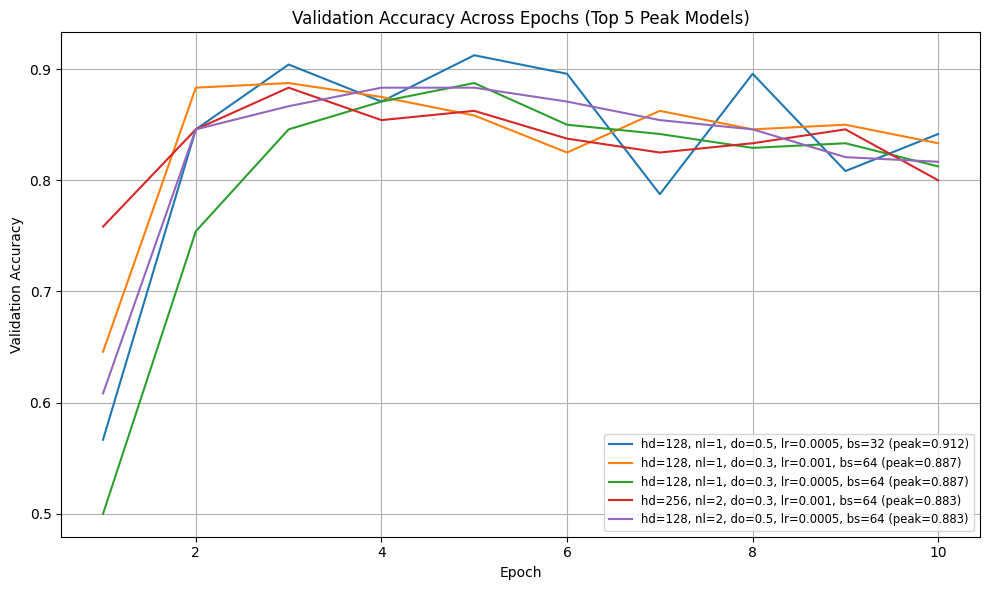

In [37]:
bilstm_top5_df = bilstm_tuning_results_df.sort_values(by="val_accuracy_peak", ascending=False).head(5)

plt.figure(figsize=(10, 6))

for i, row in bilstm_top5_df.iterrows():
    accuracies = row["val_accuracies"]
    label = (
        f"hd={row['hidden_dim']}, nl={row['num_layers']}, do={row['dropout']}, "
        f"lr={row['lr']}, bs={row['batch_size']} (peak={row['val_accuracy_peak']:.3f})"
    )
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Across Epochs (Top 5 Peak BiLSTM Models)")
plt.legend(fontsize="small", loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("bilstm_val_accuracy_top5.png")
plt.show()

## Final Prediction

In [38]:
# Final model config after tuning
bilstm_final_config = {
    "hidden_dim": 128,
    "num_layers": 1,
    "dropout": 0.5,
    "lr": 0.0005,
    "batch_size": 32,
    "epochs": 5
}

# Final model
bilstm_final_model = BiLSTMClassifier(
    vocab_size=17120,
    hidden_dim=bilstm_final_config["hidden_dim"],
    num_layers=bilstm_final_config["num_layers"],
    dropout=bilstm_final_config["dropout"]
)

# Train on full training dataset
train_loader_final = DataLoader(train_dataset_final, batch_size=bilstm_final_config["batch_size"], sampler=final_sampler)
train(bilstm_final_model, train_loader_final, epochs=bilstm_final_config["epochs"], lr=bilstm_final_config["lr"], device=device)

# Predict test set
bilstm_test_loader = DataLoader(test_dataset, batch_size=bilstm_final_config["batch_size"])
test_preds, test_probs = predict_with_confidence(bilstm_final_model, bilstm_test_loader, device=device)

# Save predictions
results_df = pd.DataFrame({
    "id": list(range(len(test_preds))),
    "label": test_preds,
    "confidence": test_probs
})
results_df.to_csv("bilstm_full_test_predictions.csv", index=False)
results_df[["id", "label"]].to_csv("bilstm_submission.csv", index=False)
print("Saved submission")

Epoch 1 — Train Loss: 0.1988


Epoch 2 — Train Loss: 0.0970


Epoch 3 — Train Loss: 0.0552


Epoch 4 — Train Loss: 0.0277


Epoch 5 — Train Loss: 0.0160


🔍 Predicting: 100%|██████████| 125/125 [02:29<00:00,  1.19s/it]

Prediction completed in 149.28 seconds.
Saved: submission.csv and full_test_predictions.csv


# Convolutional Neural Network

In [12]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_filters=100, filter_sizes=(3, 4, 5), dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), 1)

    def forward(self, x):
        x = self.embedding(x)           # (batch_size, seq_len, emb_dim)
        x = x.permute(0, 2, 1)          # (batch_size, emb_dim, seq_len)
        convs = [F.relu(conv(x)) for conv in self.convs]  # list of (batch_size, num_filters, *)
        pooled = [F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2) for c in convs]
        cat = torch.cat(pooled, dim=1)  # (batch_size, num_filters * len(filter_sizes))
        dropped = self.dropout(cat)
        logits = self.fc(dropped)
        return logits.squeeze()

## Hyperparameter Tuning

In [74]:
cnn_param_grid = {
    'embedding_dim': [128, 256],
    'num_filters': [50, 100, 150],
    'filter_sizes': [
        (3, 4, 5),
        (2, 3, 4),
        (4, 5, 6)
    ],
    'dropout': [0.3, 0.5],
    'lr': [1e-3, 5e-4],
    'batch_size':[32,64]
}

cnn_param_names = list(cnn_param_grid.keys())
cnn_param_combinations = list(itertools.product(*cnn_param_grid.values()))
cnn_tuning_results = []

# Loop over each config
for cnn_params in cnn_param_combinations:
    config = dict(zip(cnn_param_names, cnn_params))
    print(f"\nTesting CNN config: {config}")

    # Model
    model = CNNTextClassifier(
        vocab_size=17120,
        embedding_dim=config['embedding_dim'],
        num_filters=config['num_filters'],
        filter_sizes=config['filter_sizes'],
        dropout=config['dropout']
    )

    # Loader
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], sampler=train_sampler)

    # Train and validate
    val_accuracies = train_with_validation(
        model, train_loader, val_loader,
        val_labels, val_domains,
        epochs=5,
        lr=config['lr'],
        device=device
    )

    # Store results
    cnn_tuning_results.append({
        **config,
        "val_accuracy_final": val_accuracies[-1],
        "val_accuracies": val_accuracies
    })


Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1129

Validation Accuracy: 0.8583



Epoch 2 — Train Loss: 0.0353

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0182

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0133

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0081

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1605

Validation Accuracy: 0.6167



Epoch 2 — Train Loss: 0.0724

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0364

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0217

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0153

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1588

Validation Accuracy: 0.6542



Epoch 2 — Train Loss: 0.0770

Validation Accuracy: 0.8708



Epoch 3 — Train Loss: 0.0425

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0290

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0200

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1662

Validation Accuracy: 0.5250



Epoch 2 — Train Loss: 0.0977

Validation Accuracy: 0.7458



Epoch 3 — Train Loss: 0.0587

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0386

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0268

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1691

Validation Accuracy: 0.6583



Epoch 2 — Train Loss: 0.0778

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0508

Validation Accuracy: 0.9042



Epoch 4 — Train Loss: 0.0329

Validation Accuracy: 0.9292



Epoch 5 — Train Loss: 0.0255

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1809

Validation Accuracy: 0.5500



Epoch 2 — Train Loss: 0.0946

Validation Accuracy: 0.8583



Epoch 3 — Train Loss: 0.0594

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0421

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0308

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1942

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1176

Validation Accuracy: 0.7625



Epoch 3 — Train Loss: 0.0782

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0557

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0421

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1836

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1251

Validation Accuracy: 0.6792



Epoch 3 — Train Loss: 0.0851

Validation Accuracy: 0.7792



Epoch 4 — Train Loss: 0.0633

Validation Accuracy: 0.8458



Epoch 5 — Train Loss: 0.0503

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1242

Validation Accuracy: 0.8083



Epoch 2 — Train Loss: 0.0481

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0244

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0178

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0110

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1525

Validation Accuracy: 0.7208



Epoch 2 — Train Loss: 0.0744

Validation Accuracy: 0.8583



Epoch 3 — Train Loss: 0.0435

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0271

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0195

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1824

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1027

Validation Accuracy: 0.8083



Epoch 3 — Train Loss: 0.0631

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0414

Validation Accuracy: 0.9375



Epoch 5 — Train Loss: 0.0304

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1799

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1151

Validation Accuracy: 0.7625



Epoch 3 — Train Loss: 0.0780

Validation Accuracy: 0.8292



Epoch 4 — Train Loss: 0.0545

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0407

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1481

Validation Accuracy: 0.7083



Epoch 2 — Train Loss: 0.0765

Validation Accuracy: 0.8917



Epoch 3 — Train Loss: 0.0511

Validation Accuracy: 0.9333



Epoch 4 — Train Loss: 0.0375

Validation Accuracy: 0.9458



Epoch 5 — Train Loss: 0.0298

Validation Accuracy: 0.9333

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1879

Validation Accuracy: 0.5042



Epoch 2 — Train Loss: 0.1072

Validation Accuracy: 0.7833



Epoch 3 — Train Loss: 0.0758

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0531

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0420

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1871

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1178

Validation Accuracy: 0.6708



Epoch 3 — Train Loss: 0.0806

Validation Accuracy: 0.8000



Epoch 4 — Train Loss: 0.0631

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0510

Validation Accuracy: 0.9250

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.2170

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1487

Validation Accuracy: 0.5458



Epoch 3 — Train Loss: 0.1144

Validation Accuracy: 0.6250



Epoch 4 — Train Loss: 0.0931

Validation Accuracy: 0.8333



Epoch 5 — Train Loss: 0.0766

Validation Accuracy: 0.8708

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1425

Validation Accuracy: 0.7792



Epoch 2 — Train Loss: 0.0465

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0220

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0127

Validation Accuracy: 0.8583



Epoch 5 — Train Loss: 0.0091

Validation Accuracy: 0.8667

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1378

Validation Accuracy: 0.7583



Epoch 2 — Train Loss: 0.0523

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0259

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0157

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0094

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1703

Validation Accuracy: 0.5208



Epoch 2 — Train Loss: 0.0815

Validation Accuracy: 0.8625



Epoch 3 — Train Loss: 0.0416

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0264

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0166

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1804

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1071

Validation Accuracy: 0.7625



Epoch 3 — Train Loss: 0.0659

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0422

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0285

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1350

Validation Accuracy: 0.8583



Epoch 2 — Train Loss: 0.0609

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0385

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0287

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0165

Validation Accuracy: 0.8958

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1699

Validation Accuracy: 0.5458



Epoch 2 — Train Loss: 0.0907

Validation Accuracy: 0.8042



Epoch 3 — Train Loss: 0.0522

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0371

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0256

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1927

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1153

Validation Accuracy: 0.7125



Epoch 3 — Train Loss: 0.0759

Validation Accuracy: 0.8708



Epoch 4 — Train Loss: 0.0532

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0373

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 128, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.2077

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1332

Validation Accuracy: 0.5625



Epoch 3 — Train Loss: 0.0970

Validation Accuracy: 0.7417



Epoch 4 — Train Loss: 0.0695

Validation Accuracy: 0.8250



Epoch 5 — Train Loss: 0.0550

Validation Accuracy: 0.8750

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1013

Validation Accuracy: 0.9083



Epoch 2 — Train Loss: 0.0261

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0132

Validation Accuracy: 0.9375



Epoch 4 — Train Loss: 0.0064

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0047

Validation Accuracy: 0.8750

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1400

Validation Accuracy: 0.7542



Epoch 2 — Train Loss: 0.0467

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0221

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0121

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0080

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1518

Validation Accuracy: 0.7083



Epoch 2 — Train Loss: 0.0595

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0293

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0167

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0109

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1537

Validation Accuracy: 0.6250



Epoch 2 — Train Loss: 0.0748

Validation Accuracy: 0.8750



Epoch 3 — Train Loss: 0.0403

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0244

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0163

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1228

Validation Accuracy: 0.8500



Epoch 2 — Train Loss: 0.0465

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0315

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0184

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0147

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1518

Validation Accuracy: 0.7375



Epoch 2 — Train Loss: 0.0649

Validation Accuracy: 0.8875



Epoch 3 — Train Loss: 0.0378

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0262

Validation Accuracy: 0.9208



Epoch 5 — Train Loss: 0.0179

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1690

Validation Accuracy: 0.6125



Epoch 2 — Train Loss: 0.0865

Validation Accuracy: 0.8208



Epoch 3 — Train Loss: 0.0493

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0329

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0240

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1812

Validation Accuracy: 0.5042



Epoch 2 — Train Loss: 0.1059

Validation Accuracy: 0.7625



Epoch 3 — Train Loss: 0.0677

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0482

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0354

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1342

Validation Accuracy: 0.8667



Epoch 2 — Train Loss: 0.0428

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0200

Validation Accuracy: 0.8792



Epoch 4 — Train Loss: 0.0138

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0076

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1224

Validation Accuracy: 0.9042



Epoch 2 — Train Loss: 0.0465

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0222

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0140

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0096

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1372

Validation Accuracy: 0.6958



Epoch 2 — Train Loss: 0.0576

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0302

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0191

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0123

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1538

Validation Accuracy: 0.5458



Epoch 2 — Train Loss: 0.0800

Validation Accuracy: 0.8208



Epoch 3 — Train Loss: 0.0485

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0303

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0218

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1494

Validation Accuracy: 0.6958



Epoch 2 — Train Loss: 0.0616

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0388

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0248

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0188

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1448

Validation Accuracy: 0.7958



Epoch 2 — Train Loss: 0.0677

Validation Accuracy: 0.8792



Epoch 3 — Train Loss: 0.0424

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0294

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0214

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1736

Validation Accuracy: 0.5292



Epoch 2 — Train Loss: 0.0929

Validation Accuracy: 0.8833



Epoch 3 — Train Loss: 0.0583

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0380

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0293

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.2021

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1225

Validation Accuracy: 0.6458



Epoch 3 — Train Loss: 0.0843

Validation Accuracy: 0.8208



Epoch 4 — Train Loss: 0.0602

Validation Accuracy: 0.8625



Epoch 5 — Train Loss: 0.0488

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1113

Validation Accuracy: 0.8625



Epoch 2 — Train Loss: 0.0290

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0120

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0066

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0045

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1057

Validation Accuracy: 0.8958



Epoch 2 — Train Loss: 0.0306

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0136

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0076

Validation Accuracy: 0.8583



Epoch 5 — Train Loss: 0.0053

Validation Accuracy: 0.8583

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1460

Validation Accuracy: 0.7375



Epoch 2 — Train Loss: 0.0539

Validation Accuracy: 0.8875



Epoch 3 — Train Loss: 0.0270

Validation Accuracy: 0.9042



Epoch 4 — Train Loss: 0.0136

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0087

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.2196

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1054

Validation Accuracy: 0.7667



Epoch 3 — Train Loss: 0.0655

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0423

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0274

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1199

Validation Accuracy: 0.8792



Epoch 2 — Train Loss: 0.0491

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0250

Validation Accuracy: 0.8708



Epoch 4 — Train Loss: 0.0155

Validation Accuracy: 0.8708



Epoch 5 — Train Loss: 0.0118

Validation Accuracy: 0.8542

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1587

Validation Accuracy: 0.7833



Epoch 2 — Train Loss: 0.0657

Validation Accuracy: 0.8583



Epoch 3 — Train Loss: 0.0362

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0232

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0150

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1696

Validation Accuracy: 0.6083



Epoch 2 — Train Loss: 0.0815

Validation Accuracy: 0.8417



Epoch 3 — Train Loss: 0.0475

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0297

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0196

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 128, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1888

Validation Accuracy: 0.5000



Epoch 2 — Train Loss: 0.1118

Validation Accuracy: 0.6792



Epoch 3 — Train Loss: 0.0687

Validation Accuracy: 0.8625



Epoch 4 — Train Loss: 0.0475

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0323

Validation Accuracy: 0.8958

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1057

Validation Accuracy: 0.8958



Epoch 2 — Train Loss: 0.0256

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0106

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0063

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0038

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1177

Validation Accuracy: 0.8042



Epoch 2 — Train Loss: 0.0338

Validation Accuracy: 0.9250



Epoch 3 — Train Loss: 0.0128

Validation Accuracy: 0.9042



Epoch 4 — Train Loss: 0.0074

Validation Accuracy: 0.8542



Epoch 5 — Train Loss: 0.0049

Validation Accuracy: 0.8750

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1275

Validation Accuracy: 0.8250



Epoch 2 — Train Loss: 0.0450

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0198

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0117

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0063

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1676

Validation Accuracy: 0.6333



Epoch 2 — Train Loss: 0.0772

Validation Accuracy: 0.8750



Epoch 3 — Train Loss: 0.0406

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0247

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0170

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1201

Validation Accuracy: 0.8417



Epoch 2 — Train Loss: 0.0411

Validation Accuracy: 0.8917



Epoch 3 — Train Loss: 0.0237

Validation Accuracy: 0.8833



Epoch 4 — Train Loss: 0.0168

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0108

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1611

Validation Accuracy: 0.6958



Epoch 2 — Train Loss: 0.0596

Validation Accuracy: 0.9208



Epoch 3 — Train Loss: 0.0310

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0223

Validation Accuracy: 0.9292



Epoch 5 — Train Loss: 0.0123

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1431

Validation Accuracy: 0.7042



Epoch 2 — Train Loss: 0.0639

Validation Accuracy: 0.8917



Epoch 3 — Train Loss: 0.0377

Validation Accuracy: 0.9333



Epoch 4 — Train Loss: 0.0239

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0167

Validation Accuracy: 0.9250

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1868

Validation Accuracy: 0.5083



Epoch 2 — Train Loss: 0.0986

Validation Accuracy: 0.7125



Epoch 3 — Train Loss: 0.0606

Validation Accuracy: 0.8833



Epoch 4 — Train Loss: 0.0407

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0292

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1058

Validation Accuracy: 0.9000



Epoch 2 — Train Loss: 0.0278

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0109

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0072

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0047

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1589

Validation Accuracy: 0.7500



Epoch 2 — Train Loss: 0.0556

Validation Accuracy: 0.8875



Epoch 3 — Train Loss: 0.0257

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0141

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0089

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1339

Validation Accuracy: 0.8750



Epoch 2 — Train Loss: 0.0528

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0265

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0152

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0096

Validation Accuracy: 0.8667

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1757

Validation Accuracy: 0.5667



Epoch 2 — Train Loss: 0.0887

Validation Accuracy: 0.8583



Epoch 3 — Train Loss: 0.0530

Validation Accuracy: 0.8833



Epoch 4 — Train Loss: 0.0332

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0219

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1156

Validation Accuracy: 0.8042



Epoch 2 — Train Loss: 0.0462

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0257

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0246

Validation Accuracy: 0.9292



Epoch 5 — Train Loss: 0.0153

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1459

Validation Accuracy: 0.7750



Epoch 2 — Train Loss: 0.0656

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0355

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0220

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0177

Validation Accuracy: 0.9333

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1609

Validation Accuracy: 0.6583



Epoch 2 — Train Loss: 0.0745

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0483

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0310

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0216

Validation Accuracy: 0.9250

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1863

Validation Accuracy: 0.5125



Epoch 2 — Train Loss: 0.1054

Validation Accuracy: 0.7833



Epoch 3 — Train Loss: 0.0680

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0485

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0349

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1007

Validation Accuracy: 0.8375



Epoch 2 — Train Loss: 0.0220

Validation Accuracy: 0.8875



Epoch 3 — Train Loss: 0.0083

Validation Accuracy: 0.8667



Epoch 4 — Train Loss: 0.0043

Validation Accuracy: 0.8625



Epoch 5 — Train Loss: 0.0024

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1283

Validation Accuracy: 0.8417



Epoch 2 — Train Loss: 0.0353

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0146

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0069

Validation Accuracy: 0.8667



Epoch 5 — Train Loss: 0.0039

Validation Accuracy: 0.8417

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1169

Validation Accuracy: 0.8500



Epoch 2 — Train Loss: 0.0383

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0167

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0076

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0048

Validation Accuracy: 0.8542

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1724

Validation Accuracy: 0.6083



Epoch 2 — Train Loss: 0.0761

Validation Accuracy: 0.8208



Epoch 3 — Train Loss: 0.0376

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0227

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0137

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1138

Validation Accuracy: 0.9000



Epoch 2 — Train Loss: 0.0394

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0180

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0125

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0102

Validation Accuracy: 0.8583

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1306

Validation Accuracy: 0.8458



Epoch 2 — Train Loss: 0.0477

Validation Accuracy: 0.8833



Epoch 3 — Train Loss: 0.0254

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0168

Validation Accuracy: 0.8667



Epoch 5 — Train Loss: 0.0116

Validation Accuracy: 0.8583

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1509

Validation Accuracy: 0.7083



Epoch 2 — Train Loss: 0.0637

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0327

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0202

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0138

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 128, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1716

Validation Accuracy: 0.5958



Epoch 2 — Train Loss: 0.0904

Validation Accuracy: 0.7917



Epoch 3 — Train Loss: 0.0532

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0338

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0214

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1185

Validation Accuracy: 0.8667



Epoch 2 — Train Loss: 0.0301

Validation Accuracy: 0.9500



Epoch 3 — Train Loss: 0.0130

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0082

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0069

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1433

Validation Accuracy: 0.8333



Epoch 2 — Train Loss: 0.0481

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0226

Validation Accuracy: 0.9042



Epoch 4 — Train Loss: 0.0133

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0081

Validation Accuracy: 0.8750

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1342

Validation Accuracy: 0.7875



Epoch 2 — Train Loss: 0.0484

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0241

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0149

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0103

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1508

Validation Accuracy: 0.7208



Epoch 2 — Train Loss: 0.0700

Validation Accuracy: 0.8833



Epoch 3 — Train Loss: 0.0386

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0238

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0159

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1426

Validation Accuracy: 0.8208



Epoch 2 — Train Loss: 0.0569

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0393

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0243

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0185

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1535

Validation Accuracy: 0.7750



Epoch 2 — Train Loss: 0.0677

Validation Accuracy: 0.8708



Epoch 3 — Train Loss: 0.0410

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0274

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0188

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1516

Validation Accuracy: 0.7542



Epoch 2 — Train Loss: 0.0724

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0434

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0334

Validation Accuracy: 0.9333



Epoch 5 — Train Loss: 0.0233

Validation Accuracy: 0.9083

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1700

Validation Accuracy: 0.5625



Epoch 2 — Train Loss: 0.0913

Validation Accuracy: 0.8708



Epoch 3 — Train Loss: 0.0598

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0402

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0317

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1099

Validation Accuracy: 0.8875



Epoch 2 — Train Loss: 0.0322

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0191

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0108

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0067

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1536

Validation Accuracy: 0.7875



Epoch 2 — Train Loss: 0.0577

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0302

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0173

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0108

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1508

Validation Accuracy: 0.7458



Epoch 2 — Train Loss: 0.0633

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0360

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0222

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0139

Validation Accuracy: 0.8958

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1613

Validation Accuracy: 0.6417



Epoch 2 — Train Loss: 0.0786

Validation Accuracy: 0.8292



Epoch 3 — Train Loss: 0.0498

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0313

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0217

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1171

Validation Accuracy: 0.8667



Epoch 2 — Train Loss: 0.0516

Validation Accuracy: 0.9250



Epoch 3 — Train Loss: 0.0333

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0217

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0181

Validation Accuracy: 0.9292

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1881

Validation Accuracy: 0.6458



Epoch 2 — Train Loss: 0.0871

Validation Accuracy: 0.8333



Epoch 3 — Train Loss: 0.0541

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0367

Validation Accuracy: 0.9208



Epoch 5 — Train Loss: 0.0278

Validation Accuracy: 0.9250

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1693

Validation Accuracy: 0.6167



Epoch 2 — Train Loss: 0.0815

Validation Accuracy: 0.8583



Epoch 3 — Train Loss: 0.0549

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0387

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0285

Validation Accuracy: 0.9250

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1751

Validation Accuracy: 0.5333



Epoch 2 — Train Loss: 0.1043

Validation Accuracy: 0.7167



Epoch 3 — Train Loss: 0.0716

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0516

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0383

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1076

Validation Accuracy: 0.8625



Epoch 2 — Train Loss: 0.0276

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0122

Validation Accuracy: 0.8625



Epoch 4 — Train Loss: 0.0089

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0056

Validation Accuracy: 0.8625

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1349

Validation Accuracy: 0.8458



Epoch 2 — Train Loss: 0.0412

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0185

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0109

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0071

Validation Accuracy: 0.8958

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1227

Validation Accuracy: 0.8375



Epoch 2 — Train Loss: 0.0410

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0202

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0114

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0083

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1581

Validation Accuracy: 0.6167



Epoch 2 — Train Loss: 0.0706

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0356

Validation Accuracy: 0.9042



Epoch 4 — Train Loss: 0.0218

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0148

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1138

Validation Accuracy: 0.7958



Epoch 2 — Train Loss: 0.0451

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0259

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0167

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0150

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1541

Validation Accuracy: 0.7500



Epoch 2 — Train Loss: 0.0625

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0329

Validation Accuracy: 0.9333



Epoch 4 — Train Loss: 0.0223

Validation Accuracy: 0.8917



Epoch 5 — Train Loss: 0.0149

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1565

Validation Accuracy: 0.6667



Epoch 2 — Train Loss: 0.0689

Validation Accuracy: 0.8708



Epoch 3 — Train Loss: 0.0410

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0274

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0190

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 256, 'num_filters': 50, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1499

Validation Accuracy: 0.6500



Epoch 2 — Train Loss: 0.0748

Validation Accuracy: 0.8708



Epoch 3 — Train Loss: 0.0462

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0327

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0245

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0939

Validation Accuracy: 0.9167



Epoch 2 — Train Loss: 0.0210

Validation Accuracy: 0.8833



Epoch 3 — Train Loss: 0.0085

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0039

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0028

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1026

Validation Accuracy: 0.8792



Epoch 2 — Train Loss: 0.0255

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0114

Validation Accuracy: 0.8833



Epoch 4 — Train Loss: 0.0051

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0031

Validation Accuracy: 0.8708

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1093

Validation Accuracy: 0.8875



Epoch 2 — Train Loss: 0.0310

Validation Accuracy: 0.8917



Epoch 3 — Train Loss: 0.0136

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0072

Validation Accuracy: 0.8917



Epoch 5 — Train Loss: 0.0041

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1210

Validation Accuracy: 0.7625



Epoch 2 — Train Loss: 0.0410

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0192

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0110

Validation Accuracy: 0.8792



Epoch 5 — Train Loss: 0.0076

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1054

Validation Accuracy: 0.9083



Epoch 2 — Train Loss: 0.0369

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0210

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0148

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0146

Validation Accuracy: 0.8958

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1333

Validation Accuracy: 0.8625



Epoch 2 — Train Loss: 0.0442

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0253

Validation Accuracy: 0.9042



Epoch 4 — Train Loss: 0.0139

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0109

Validation Accuracy: 0.8917

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1497

Validation Accuracy: 0.7917



Epoch 2 — Train Loss: 0.0591

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0309

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0187

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0140

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1568

Validation Accuracy: 0.5708



Epoch 2 — Train Loss: 0.0704

Validation Accuracy: 0.8833



Epoch 3 — Train Loss: 0.0421

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0265

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0187

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0785

Validation Accuracy: 0.9042



Epoch 2 — Train Loss: 0.0216

Validation Accuracy: 0.8875



Epoch 3 — Train Loss: 0.0098

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0062

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0037

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1203

Validation Accuracy: 0.8750



Epoch 2 — Train Loss: 0.0349

Validation Accuracy: 0.9250



Epoch 3 — Train Loss: 0.0154

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0078

Validation Accuracy: 0.9208



Epoch 5 — Train Loss: 0.0051

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1182

Validation Accuracy: 0.7583



Epoch 2 — Train Loss: 0.0380

Validation Accuracy: 0.9208



Epoch 3 — Train Loss: 0.0185

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0106

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0066

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1284

Validation Accuracy: 0.7875



Epoch 2 — Train Loss: 0.0484

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0254

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0156

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0104

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1109

Validation Accuracy: 0.9208



Epoch 2 — Train Loss: 0.0429

Validation Accuracy: 0.9208



Epoch 3 — Train Loss: 0.0268

Validation Accuracy: 0.9292



Epoch 4 — Train Loss: 0.0168

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0116

Validation Accuracy: 0.9250

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1263

Validation Accuracy: 0.9000



Epoch 2 — Train Loss: 0.0484

Validation Accuracy: 0.9083



Epoch 3 — Train Loss: 0.0274

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0174

Validation Accuracy: 0.9083



Epoch 5 — Train Loss: 0.0125

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1456

Validation Accuracy: 0.8375



Epoch 2 — Train Loss: 0.0631

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0353

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0228

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0175

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1675

Validation Accuracy: 0.6500



Epoch 2 — Train Loss: 0.0828

Validation Accuracy: 0.8583



Epoch 3 — Train Loss: 0.0516

Validation Accuracy: 0.8833



Epoch 4 — Train Loss: 0.0379

Validation Accuracy: 0.9125



Epoch 5 — Train Loss: 0.0247

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0791

Validation Accuracy: 0.8792



Epoch 2 — Train Loss: 0.0180

Validation Accuracy: 0.8708



Epoch 3 — Train Loss: 0.0072

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0036

Validation Accuracy: 0.8583



Epoch 5 — Train Loss: 0.0029

Validation Accuracy: 0.8958

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1172

Validation Accuracy: 0.8875



Epoch 2 — Train Loss: 0.0267

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0101

Validation Accuracy: 0.8792



Epoch 4 — Train Loss: 0.0059

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0039

Validation Accuracy: 0.8583

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1049

Validation Accuracy: 0.9125



Epoch 2 — Train Loss: 0.0267

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0115

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0054

Validation Accuracy: 0.8625



Epoch 5 — Train Loss: 0.0041

Validation Accuracy: 0.8583

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1162

Validation Accuracy: 0.8625



Epoch 2 — Train Loss: 0.0343

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0164

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0093

Validation Accuracy: 0.8625



Epoch 5 — Train Loss: 0.0052

Validation Accuracy: 0.8458

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1018

Validation Accuracy: 0.8750



Epoch 2 — Train Loss: 0.0378

Validation Accuracy: 0.8708



Epoch 3 — Train Loss: 0.0199

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0157

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0078

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1140

Validation Accuracy: 0.7625



Epoch 2 — Train Loss: 0.0420

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0221

Validation Accuracy: 0.9125



Epoch 4 — Train Loss: 0.0125

Validation Accuracy: 0.8917



Epoch 5 — Train Loss: 0.0096

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1181

Validation Accuracy: 0.8500



Epoch 2 — Train Loss: 0.0420

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0232

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0151

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0095

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 256, 'num_filters': 100, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1714

Validation Accuracy: 0.5958



Epoch 2 — Train Loss: 0.0702

Validation Accuracy: 0.8875



Epoch 3 — Train Loss: 0.0388

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0248

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0168

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0735

Validation Accuracy: 0.8708



Epoch 2 — Train Loss: 0.0155

Validation Accuracy: 0.8542



Epoch 3 — Train Loss: 0.0093

Validation Accuracy: 0.8583



Epoch 4 — Train Loss: 0.0037

Validation Accuracy: 0.8875



Epoch 5 — Train Loss: 0.0032

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.0963

Validation Accuracy: 0.9042



Epoch 2 — Train Loss: 0.0238

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0084

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0043

Validation Accuracy: 0.8583



Epoch 5 — Train Loss: 0.0029

Validation Accuracy: 0.8583

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1033

Validation Accuracy: 0.8833



Epoch 2 — Train Loss: 0.0263

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0103

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0048

Validation Accuracy: 0.8458



Epoch 5 — Train Loss: 0.0028

Validation Accuracy: 0.8417

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1209

Validation Accuracy: 0.8500



Epoch 2 — Train Loss: 0.0394

Validation Accuracy: 0.9333



Epoch 3 — Train Loss: 0.0169

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0095

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0056

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1002

Validation Accuracy: 0.8792



Epoch 2 — Train Loss: 0.0328

Validation Accuracy: 0.8792



Epoch 3 — Train Loss: 0.0174

Validation Accuracy: 0.8917



Epoch 4 — Train Loss: 0.0118

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0110

Validation Accuracy: 0.9167

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1262

Validation Accuracy: 0.9083



Epoch 2 — Train Loss: 0.0382

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0201

Validation Accuracy: 0.9083



Epoch 4 — Train Loss: 0.0103

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0070

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1150

Validation Accuracy: 0.8875



Epoch 2 — Train Loss: 0.0407

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0202

Validation Accuracy: 0.8708



Epoch 4 — Train Loss: 0.0122

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0076

Validation Accuracy: 0.9292

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (3, 4, 5), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1624

Validation Accuracy: 0.7083



Epoch 2 — Train Loss: 0.0649

Validation Accuracy: 0.8917



Epoch 3 — Train Loss: 0.0382

Validation Accuracy: 0.9042



Epoch 4 — Train Loss: 0.0224

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0160

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0880

Validation Accuracy: 0.8958



Epoch 2 — Train Loss: 0.0205

Validation Accuracy: 0.9292



Epoch 3 — Train Loss: 0.0094

Validation Accuracy: 0.8792



Epoch 4 — Train Loss: 0.0039

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0028

Validation Accuracy: 0.9125

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1056

Validation Accuracy: 0.8958



Epoch 2 — Train Loss: 0.0247

Validation Accuracy: 0.9208



Epoch 3 — Train Loss: 0.0102

Validation Accuracy: 0.8958



Epoch 4 — Train Loss: 0.0050

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0032

Validation Accuracy: 0.8958

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1099

Validation Accuracy: 0.8583



Epoch 2 — Train Loss: 0.0304

Validation Accuracy: 0.9292



Epoch 3 — Train Loss: 0.0136

Validation Accuracy: 0.9250



Epoch 4 — Train Loss: 0.0072

Validation Accuracy: 0.8958



Epoch 5 — Train Loss: 0.0043

Validation Accuracy: 0.8875

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1494

Validation Accuracy: 0.8000



Epoch 2 — Train Loss: 0.0551

Validation Accuracy: 0.8958



Epoch 3 — Train Loss: 0.0291

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0173

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0111

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0995

Validation Accuracy: 0.8583



Epoch 2 — Train Loss: 0.0335

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0173

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0161

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0144

Validation Accuracy: 0.9292

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1335

Validation Accuracy: 0.9208



Epoch 2 — Train Loss: 0.0437

Validation Accuracy: 0.9208



Epoch 3 — Train Loss: 0.0232

Validation Accuracy: 0.9333



Epoch 4 — Train Loss: 0.0152

Validation Accuracy: 0.9208



Epoch 5 — Train Loss: 0.0097

Validation Accuracy: 0.8833

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1275

Validation Accuracy: 0.7542



Epoch 2 — Train Loss: 0.0489

Validation Accuracy: 0.9167



Epoch 3 — Train Loss: 0.0256

Validation Accuracy: 0.9375



Epoch 4 — Train Loss: 0.0150

Validation Accuracy: 0.9250



Epoch 5 — Train Loss: 0.0100

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (2, 3, 4), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1409

Validation Accuracy: 0.8167



Epoch 2 — Train Loss: 0.0618

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0343

Validation Accuracy: 0.9208



Epoch 4 — Train Loss: 0.0218

Validation Accuracy: 0.9167



Epoch 5 — Train Loss: 0.0166

Validation Accuracy: 0.9042

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0686

Validation Accuracy: 0.9083



Epoch 2 — Train Loss: 0.0165

Validation Accuracy: 0.8833



Epoch 3 — Train Loss: 0.0061

Validation Accuracy: 0.8667



Epoch 4 — Train Loss: 0.0046

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0034

Validation Accuracy: 0.8792

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.0957

Validation Accuracy: 0.8833



Epoch 2 — Train Loss: 0.0177

Validation Accuracy: 0.8833



Epoch 3 — Train Loss: 0.0069

Validation Accuracy: 0.8750



Epoch 4 — Train Loss: 0.0035

Validation Accuracy: 0.8750



Epoch 5 — Train Loss: 0.0020

Validation Accuracy: 0.8667

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0908

Validation Accuracy: 0.9000



Epoch 2 — Train Loss: 0.0185

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0069

Validation Accuracy: 0.8458



Epoch 4 — Train Loss: 0.0030

Validation Accuracy: 0.8708



Epoch 5 — Train Loss: 0.0021

Validation Accuracy: 0.8542

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1035

Validation Accuracy: 0.8875



Epoch 2 — Train Loss: 0.0286

Validation Accuracy: 0.8917



Epoch 3 — Train Loss: 0.0125

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0066

Validation Accuracy: 0.8625



Epoch 5 — Train Loss: 0.0040

Validation Accuracy: 0.8500

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 32}



Epoch 1 — Train Loss: 0.0946

Validation Accuracy: 0.9042



Epoch 2 — Train Loss: 0.0315

Validation Accuracy: 0.8792



Epoch 3 — Train Loss: 0.0186

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0091

Validation Accuracy: 0.8708



Epoch 5 — Train Loss: 0.0082

Validation Accuracy: 0.9208

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1311

Validation Accuracy: 0.8167



Epoch 2 — Train Loss: 0.0341

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0181

Validation Accuracy: 0.8875



Epoch 4 — Train Loss: 0.0099

Validation Accuracy: 0.9042



Epoch 5 — Train Loss: 0.0070

Validation Accuracy: 0.9000

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 32}



Epoch 1 — Train Loss: 0.1199

Validation Accuracy: 0.8667



Epoch 2 — Train Loss: 0.0371

Validation Accuracy: 0.9042



Epoch 3 — Train Loss: 0.0170

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0120

Validation Accuracy: 0.9000



Epoch 5 — Train Loss: 0.0086

Validation Accuracy: 0.8583

Testing CNN config: {'embedding_dim': 256, 'num_filters': 150, 'filter_sizes': (4, 5, 6), 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}



Epoch 1 — Train Loss: 0.1628

Validation Accuracy: 0.7417



Epoch 2 — Train Loss: 0.0601

Validation Accuracy: 0.9000



Epoch 3 — Train Loss: 0.0322

Validation Accuracy: 0.9000



Epoch 4 — Train Loss: 0.0187

Validation Accuracy: 0.8833



Epoch 5 — Train Loss: 0.0120

Validation Accuracy: 0.9000


In [77]:
cnn_tuning_results_df = pd.DataFrame(cnn_tuning_results)

cnn_tuning_results_df["val_accuracy_peak"] = cnn_tuning_results_df["val_accuracies"].apply(max)
cnn_tuning_results_df["epoch_peak"] = cnn_tuning_results_df["val_accuracies"].apply(lambda x: x.index(max(x)) + 1)

cnn_tuning_results_df = cnn_tuning_results_df.sort_values(by="val_accuracy_peak", ascending=False)

print(cnn_tuning_results_df[[
    "embedding_dim", "num_filters", "filter_sizes", "dropout", "lr", "batch_size",
    "val_accuracy_peak", "epoch_peak", "val_accuracy_final"
]].to_string(index=False))

 embedding_dim  num_filters filter_sizes  dropout     lr  batch_size  val_accuracy_peak  epoch_peak  val_accuracy_final
           256           50    (3, 4, 5)      0.3 0.0010          32           0.950000           2            0.887500
           128           50    (2, 3, 4)      0.5 0.0010          32           0.945833           4            0.933333
           128           50    (2, 3, 4)      0.3 0.0005          32           0.937500           4            0.916667
           128          100    (3, 4, 5)      0.3 0.0010          32           0.937500           3            0.875000
           256          150    (2, 3, 4)      0.5 0.0005          32           0.937500           3            0.920833
           256          150    (2, 3, 4)      0.5 0.0010          64           0.933333           3            0.883333
           256           50    (4, 5, 6)      0.5 0.0010          64           0.933333           3            0.900000
           128          150    (3, 4, 5)

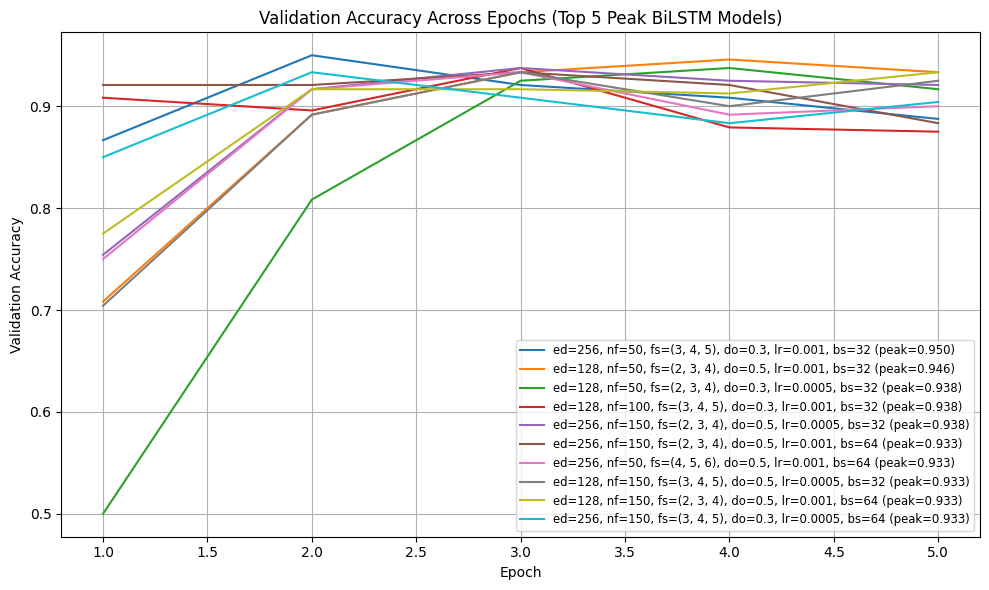

In [80]:
cnn_top_df = cnn_tuning_results_df.sort_values(by="val_accuracy_peak", ascending=False).head(10)

plt.figure(figsize=(10, 6))

for i, row in cnn_top_df.iterrows():
    accuracies = row["val_accuracies"]
    label = (
        f"ed={row['embedding_dim']}, nf={row['num_filters']}, fs={row['filter_sizes']}, do={row['dropout']}, "
        f"lr={row['lr']}, bs={row['batch_size']} (peak={row['val_accuracy_peak']:.3f})"
    )
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Across Epochs (Top Peak CNN Models)")
plt.legend(fontsize="small", loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_val_accuracy_top5.png")
plt.show()

# Manual Validation

Notes: Trying larger filter size space (2,3,4,5), not gaining any additional information

In [23]:
cnn_params = {
    'embedding_dim': 128,
    'num_filters': 50,
    'filter_sizes': (2, 3, 4),
    'dropout': 0.5,
    'lr': 0.001,
    'batch_size':32
}

validation_model = CNNTextClassifier(
        vocab_size=17120,
        embedding_dim=cnn_params['embedding_dim'],
        num_filters=cnn_params['num_filters'],
        filter_sizes=cnn_params['filter_sizes'],
        dropout=cnn_params['dropout']
    )

# Loader
train_loader = DataLoader(train_dataset, batch_size=cnn_params['batch_size'], sampler=train_sampler)

# Train and validate
val_accuracies = train_with_validation(
    validation_model, train_loader, val_loader,
    val_labels, val_domains,
    epochs=6,
    lr=cnn_params['lr'],
    device=device
)


Epoch 1 — Train Loss: 0.1470

Validation Accuracy: 0.6542



Epoch 2 — Train Loss: 0.0744

Validation Accuracy: 0.9125



Epoch 3 — Train Loss: 0.0493

Validation Accuracy: 0.9167



Epoch 4 — Train Loss: 0.0362

Validation Accuracy: 0.9333



Epoch 5 — Train Loss: 0.0283

Validation Accuracy: 0.9125



Epoch 6 — Train Loss: 0.0214

Validation Accuracy: 0.9042


# CNN Final Prediction

In [15]:
# Training CNN
cnn_final_config = {
    'embedding_dim': 128,
    'num_filters': 50,
    'filter_sizes': (2, 3, 4),
    'dropout': 0.5,
    'lr': 0.001,
    'batch_size':32
}

cnn_final_model = CNNTextClassifier(
    vocab_size=17120,
    embedding_dim=cnn_final_config['embedding_dim'],
    num_filters=cnn_final_config['num_filters'],
    filter_sizes=cnn_final_config['filter_sizes'],
    dropout=cnn_final_config['dropout']
)


# Train on full training dataset
train_loader_final = DataLoader(train_dataset_final, batch_size=cnn_final_config["batch_size"], sampler=final_sampler)
train(cnn_final_model, train_loader_final, epochs=4, lr=cnn_final_config["lr"], device=device)

# Predict test set
test_preds, test_probs = predict_with_confidence(cnn_final_model, test_loader, device=device)

results_df = pd.DataFrame({
    "id": list(range(len(test_preds))),
    "label": test_preds,
    "confidence": test_probs
})
results_df.to_csv("cnn_full_test_predictions_2.csv", index=False)
results_df[["id", "label"]].to_csv("cnn_submission_2.csv", index=False)
print("Saved submission")

Epoch 1 — Train Loss: 0.1745


Epoch 2 — Train Loss: 0.0889


Epoch 3 — Train Loss: 0.0633


Epoch 4 — Train Loss: 0.0428


Saved submission


# Simple Aggregated Stats MLP Model
Should be an effective ensemble for CNN

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [172]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

In [173]:
# Load domain1
d1_texts, d1_labels = load_json_lines("data/domain1_train_data.json")
d1_domains = [0] * len(d1_labels)  

# Load domain2
d2_texts, d2_labels = load_json_lines("data/domain2_train_data.json")
d2_domains = [1] * len(d2_labels)  

test_texts = load_test_json("data/test_data.json")

texts = d1_texts + d2_texts
labels = d1_labels + d2_labels
domains = d1_domains + d2_domains

train_texts, train_labels, train_domains, val_texts, val_labels, val_domains = stratified_train_val_split(
    texts, labels, domains, val_size_per_group=60
)

# For training set
train_sampler = create_weighted_sampler(train_domains, train_labels)

# For full dataset (e.g., final training)
full_sampler = create_weighted_sampler(domains, labels)

In [185]:
# ========== Preprocess Training + Validation Sets ==========
train_text_strings = tokens_to_text(train_texts)
val_text_strings = tokens_to_text(val_texts)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_text_strings).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_text_strings).toarray()

svd = TruncatedSVD(n_components=100, random_state=42)
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd.transform(X_val_tfidf)

embedding_layer = nn.Embedding(17120, 128, padding_idx=0)
embedding_matrix = embedding_layer.weight.detach().cpu().numpy()

train_embed_stats = compute_embed_stats(train_texts, embedding_matrix)
val_embed_stats = compute_embed_stats(val_texts, embedding_matrix)

X_train_raw = np.hstack([X_train_tfidf_reduced, train_embed_stats])
X_val_raw = np.hstack([X_val_tfidf_reduced, val_embed_stats])

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_raw)
X_val_std = scaler.transform(X_val_raw)

# ========== Training Setup ==========
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_std, dtype=torch.float32)
y_val = torch.tensor(val_labels, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train)
val_dataset = TensorDataset(X_val_tensor, y_val)

train_sampler = create_weighted_sampler(train_domains, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ========== MLP Training ==========
input_dim = X_train_tensor.shape[1]
mlp_model = MLPClassifier(input_dim=input_dim, hidden_dim=256, dropout=0.5).to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(1, 11):
    mlp_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = mlp_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} — Train Loss: {total_loss / len(train_loader):.4f}")

    # Validation
    mlp_model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = mlp_model(X_batch)
            probs = torch.sigmoid(logits)
            preds.extend((probs >= 0.5).int().cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    acc = accuracy_score(targets, preds)
    print(f"Validation Accuracy: {acc:.4f}")

Epoch 1 — Train Loss: 0.1281
Validation Accuracy: 0.8167
Epoch 2 — Train Loss: 0.0677
Validation Accuracy: 0.9083
Epoch 3 — Train Loss: 0.0461
Validation Accuracy: 0.8958
Epoch 4 — Train Loss: 0.0349
Validation Accuracy: 0.8833
Epoch 5 — Train Loss: 0.0261
Validation Accuracy: 0.8917
Epoch 6 — Train Loss: 0.0219
Validation Accuracy: 0.8958
Epoch 7 — Train Loss: 0.0159
Validation Accuracy: 0.8917
Epoch 8 — Train Loss: 0.0189
Validation Accuracy: 0.9000
Epoch 9 — Train Loss: 0.0132
Validation Accuracy: 0.8958
Epoch 10 — Train Loss: 0.0109
Validation Accuracy: 0.8917


Epoch 6 is about peak

## Training on Full Dataset for Prediction

In [176]:
# ========== Preprocess Full Train + Test ==========
all_text_strings = tokens_to_text(texts)
test_text_strings = tokens_to_text(test_texts)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_all_tfidf = tfidf_vectorizer.fit_transform(all_text_strings).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_text_strings).toarray()

svd = TruncatedSVD(n_components=100, random_state=42)
X_all_tfidf_reduced = svd.fit_transform(X_all_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

embedding_layer = nn.Embedding(17120, 128, padding_idx=0)
embedding_matrix = embedding_layer.weight.detach().cpu().numpy()

all_embed_stats = compute_embed_stats(texts, embedding_matrix)
test_embed_stats = compute_embed_stats(test_texts, embedding_matrix)

X_all_raw = np.hstack([X_all_tfidf_reduced, all_embed_stats])
X_test_raw = np.hstack([X_test_tfidf_reduced, test_embed_stats])

scaler = StandardScaler()
X_all_std = scaler.fit_transform(X_all_raw)
X_test_std = scaler.transform(X_test_raw)

# ========== Final MLP Training ==========
X_train_tensor = torch.tensor(X_all_std, dtype=torch.float32)
y_train = torch.tensor(labels, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=create_weighted_sampler(domains, labels))
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=64)

mlp_model = MLPClassifier(input_dim=X_train_tensor.shape[1], hidden_dim=256, dropout=0.5).to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(1, 7):
    mlp_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = mlp_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} — Train Loss: {total_loss / len(train_loader):.4f}")

# ========== Test Prediction ==========
mlp_model.eval()
test_preds, test_probs = [], []

with torch.no_grad():
    for (X_batch,) in tqdm(test_loader, desc="Predicting"):
        X_batch = X_batch.to(device)
        logits = mlp_model(X_batch)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).int().cpu().numpy()
        test_preds.extend(preds)
        test_probs.extend(probs.cpu().numpy())

results_df = pd.DataFrame({
    "id": list(range(len(test_preds))),
    "label": test_preds,
    "confidence": test_probs
})

results_df.to_csv("mlp_full_test_predictions.csv", index=False)
results_df[["id", "label"]].to_csv("mlp_submission.csv", index=False)
print("Saved submission")

Epoch 1 — Train Loss: 0.1330
Epoch 2 — Train Loss: 0.0698
Epoch 3 — Train Loss: 0.0453
Epoch 4 — Train Loss: 0.0368
Epoch 5 — Train Loss: 0.0287
Epoch 6 — Train Loss: 0.0237


Predicting: 100%|██████████| 63/63 [00:00<00:00, 4658.78it/s]

Saved submission


# Ensemble Model Practice

In [88]:
# Training BiLSTM
bilstm_final_config = {
    "hidden_dim": 128,
    "num_layers": 1,
    "dropout": 0.5,
    "lr": 0.0005,
    "batch_size": 32,
    "epochs": 5
}

bilstm_final_model = BiLSTMClassifier(
    vocab_size=17120,
    hidden_dim=bilstm_final_config["hidden_dim"],
    num_layers=bilstm_final_config["num_layers"],
    dropout=bilstm_final_config["dropout"]
)

train_loader = DataLoader(train_dataset, batch_size=bilstm_final_config["batch_size"], sampler=train_sampler)
train(bilstm_final_model, train_loader, epochs=bilstm_final_config["epochs"], lr=bilstm_final_config["lr"], device=device)

# Training CNN
cnn_final_config = {
    'embedding_dim': 128,
    'num_filters': 50,
    'filter_sizes': (2, 3, 4),
    'dropout': 0.5,
    'lr': 0.001,
    'batch_size':32
}

cnn_final_model = CNNTextClassifier(
    vocab_size=17120,
    embedding_dim=cnn_final_config['embedding_dim'],
    num_filters=cnn_final_config['num_filters'],
    filter_sizes=cnn_final_config['filter_sizes'],
    dropout=cnn_final_config['dropout']
)

train_loader_final = DataLoader(train_dataset, batch_size=cnn_final_config["batch_size"], sampler=train_sampler)
train(cnn_final_model, train_loader_final, epochs=4, lr=cnn_final_config["lr"], device=device)

# Predict on validation set to train simple logistic regression ensemble classifier

bilstm_val_preds, bilstm_val_probs = predict_with_confidence(bilstm_final_model, val_loader, device=device)
cnn_val_preds, cnn_val_probs = predict_with_confidence(cnn_final_model, val_loader, device=device)

X_meta = np.vstack([bilstm_val_probs, cnn_val_probs]).T
y_meta = np.array(val_labels)

meta_clf = LogisticRegression()
meta_clf.fit(X_meta, y_meta)

# Predict on test set

bilstm_test_preds, bilstm_test_probs = predict_with_confidence(bilstm_final_model, test_loader, device=device)
cnn_test_preds, cnn_test_probs = predict_with_confidence(cnn_final_model, test_loader, device=device)

X_test_meta = np.vstack([bilstm_test_probs, cnn_test_probs]).T
ensemble_preds = meta_clf.predict(X_test_meta)
ensemble_results_df = pd.DataFrame({
    "id": list(range(len(ensemble_preds))),
    "label": ensemble_preds.astype(int)
})
ensemble_results_df.to_csv("submission_ensemble.csv", index=False)

Epoch 1 — Train Loss: 0.1843


Epoch 2 — Train Loss: 0.0895


Epoch 3 — Train Loss: 0.0460


Epoch 4 — Train Loss: 0.0207


Epoch 5 — Train Loss: 0.0160


Epoch 1 — Train Loss: 0.1581


Epoch 2 — Train Loss: 0.0818


Epoch 3 — Train Loss: 0.0530


Epoch 4 — Train Loss: 0.0420
